## 목적
- imbalanced class problem을 해결하기 위한 방안 탐색

## 실험 대상
- binary: apple 단말기 선택 여부
- multi: 단말기 추천(삼성, lg, apple, 기타)

## 성능 향상 방안
1. sampling
    1. random under sampling
    2. random over sampling
    3. cluster-based ober sampling
    4. SMOTE
    5. combination of over and under sampling
2. anomaly detection
3. ensemble learning
4. algorithm class weight

## 사용 모델
1. random forest
2. xgb
3. lgb

## 데이터
- input: comm.user_profile_matrix_for_device_monthly
- label: dumbo.user_label_matrix_for_reco_equip_monthly

## [중요]학습 데이터 결정
- 기변의 경우, 신규 단말기 출시에 따른 영향이 굉장히 큼
- 학습 모델이 제조사 별 선호도를 잘 예측해준다면 추후 큰 도움이 될 것
- 비슷한 feature를 가진 사람이라도 월 마다 다른 라벨을 가진다면 학습이 잘 안됨.. 이를 테스트해 보고 싶음(즉 학습데이터 시점에 따라서 다른 모델을 가질까? 그렇다면 어떻게 해야하나?)
    - 6,7을 평소 데이터라고 생각하고 / 8,9를 삼성 단말기 출시 / 10을 애플 단말기 출시로 보고 모델링

In [1]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/dominic_workspace/data/'
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

## load data

In [3]:
df_meta = load_from_hive(hive_connection('dmig'), "select * from comm.device_meta where ym = '201910'")

2019-11-05 22:39:23,620 - YE_HIVE - INFO - ...tmp_db name = tmp_20191105_22_39_23_39aae6c5399b4e83e24ae4640c3129cc2cf6eb4a
2019-11-05 22:39:23,622 - YE_HIVE - INFO - Start creating table
2019-11-05 22:39:23,623 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191105_22_39_23_39aae6c5399b4e83e24ae4640c3129cc2cf6eb4a
2019-11-05 22:39:23,678 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191105_22_39_23_39aae6c5399b4e83e24ae4640c3129cc2cf6eb4a' is done
2019-11-05 22:42:03,695 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191105_22_39_23_39aae6c5399b4e83e24ae4640c3129cc2cf6eb4a 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.device_meta where ym = '201910'' is done
2019-11-05 22:42:03,961 - YE_HIVE - INFO - Elapsed Time = 160.34
2019-11-05 22:42:03,963 - YE_HIVE - I

In [4]:
df_meta.shape

(1801, 23)

In [5]:
label_sql = """
select * from dumbo.user_label_matrix_for_reco_equip_monthly
"""

In [6]:
df_label = load_from_hive(hive_connection('dmig'), label_sql)

2019-11-05 22:42:13,515 - YE_HIVE - INFO - ...tmp_db name = tmp_20191105_22_42_13_362fb0fe187f1819eed3aae11954848f5954e593
2019-11-05 22:42:13,518 - YE_HIVE - INFO - Start creating table
2019-11-05 22:42:13,519 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191105_22_42_13_362fb0fe187f1819eed3aae11954848f5954e593
2019-11-05 22:42:13,578 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191105_22_42_13_362fb0fe187f1819eed3aae11954848f5954e593' is done
2019-11-05 22:44:57,184 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191105_22_42_13_362fb0fe187f1819eed3aae11954848f5954e593 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select * from dumbo.user_label_matrix_for_reco_equip_monthly
' is done
2019-11-05 22:44:57,439 - YE_HIVE - INFO - Elapsed Time = 163.92
2019-11-05 22:44:57,441 -

In [7]:
df_label.shape

(3010198, 17)

## EDA

In [7]:
df_label.ym.value_counts()

201908    490421
201903    414254
201905    389121
201907    381662
201904    341435
201906    341076
201909    332719
201910    319510
Name: ym, dtype: int64

## 주요 단말기 출시
- 갤럭시 폴드: 20190906
- 아이폰11/PRO/MAX: 20191025
- 갤럭시노트10: 20190820

In [21]:
for ym in df_label.ym.value_counts().sort_index().index:
    print('='*50)
    print('ym: ', ym)
    print('total: ', df_label[df_label['ym']==ym].shape[0])
    display(df_label[df_label['ym']==ym]['mfact_nm'].value_counts().head(5)/df_label[df_label['ym']==ym].shape[0])

ym:  201903
total:  414254


삼성전자     0.813885
Apple    0.110029
LG전자     0.068402
기타       0.007684
Name: mfact_nm, dtype: float64

ym:  201904
total:  341435


삼성전자     0.780257
Apple    0.128180
LG전자     0.086587
기타       0.004976
Name: mfact_nm, dtype: float64

ym:  201905
total:  389121


삼성전자     0.699728
LG전자     0.178441
Apple    0.115157
기타       0.006674
Name: mfact_nm, dtype: float64

ym:  201906
total:  341076


삼성전자     0.733892
LG전자     0.138708
Apple    0.123316
기타       0.004084
Name: mfact_nm, dtype: float64

ym:  201907
total:  381662


삼성전자     0.765114
LG전자     0.131155
Apple    0.101291
기타       0.002439
Name: mfact_nm, dtype: float64

ym:  201908
total:  490421


삼성전자     0.847664
LG전자     0.079542
Apple    0.070354
기타       0.002441
Name: mfact_nm, dtype: float64

ym:  201909
total:  332719


삼성전자     0.852807
LG전자     0.080065
Apple    0.064640
기타       0.002489
Name: mfact_nm, dtype: float64

ym:  201910
total:  319510


삼성전자     0.643823
Apple    0.254965
LG전자     0.099311
기타       0.001900
Name: mfact_nm, dtype: float64

## [중요]학습 데이터 결정
- 기변의 경우, 신규 단말기 출시에 따른 영향이 굉장히 큼
- 학습 모델이 제조사 별 선호도를 잘 예측해준다면 추후 큰 도움이 될 것
- 비슷한 feature를 가진 사람이라도 월 마다 다른 라벨을 가진다면 학습이 잘 안됨.. 이를 테스트해 보고 싶음(즉 학습데이터 시점에 따라서 다른 모델을 가질까? 그렇다면 어떻게 해야하나?)
    - 6,7을 평소 데이터라고 생각하고 / 8,9를 삼성 단말기 출시 / 10을 애플 단말기 출시로 보고 모델링

In [ ]:
그럼 일단 6,7을 각 dev, tst 데이터로 사용

## binary
- Y: apple
- N: not apple

In [8]:
df_input = load_from_hive(hive_connection('dmig'), "select * from comm.user_input_matrix_for_device_monthly where ym between '201906' and '201907'")

2019-11-05 22:45:33,433 - YE_HIVE - INFO - ...tmp_db name = tmp_20191105_22_45_33_41d946542bb4d4f449c1d6e6562fc32ac688cae8
2019-11-05 22:45:33,435 - YE_HIVE - INFO - Start creating table
2019-11-05 22:45:33,436 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191105_22_45_33_41d946542bb4d4f449c1d6e6562fc32ac688cae8
2019-11-05 22:45:33,485 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191105_22_45_33_41d946542bb4d4f449c1d6e6562fc32ac688cae8' is done
2019-11-05 22:48:21,802 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191105_22_45_33_41d946542bb4d4f449c1d6e6562fc32ac688cae8 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        select * from comm.user_input_matrix_for_device_monthly where ym between '201906' and '201907'' is done
2019-11-05 22:48:22,078 - YE_HIVE - INFO - Elapsed Time = 

In [9]:
df_input.shape

(38849103, 54)

In [10]:
# df_dev = df_input[df_input.ym=='201906']
# df_tst = df_input[df_input.ym=='201907']

# df_dev.shape, df_tst.shape

((19323068, 54), (19526035, 54))

In [26]:
sql = """
select * 
from comm.user_input_matrix_for_device_monthly 
where ym = '201906'
"""
df_dev = load_from_hive(hive_connection('dmig'),sql)

2019-11-06 05:50:38,458 - YE_HIVE - INFO - ...tmp_db name = tmp_20191106_05_50_38_068a723c3c5f73a7bef21c24b75f03a31e344c62
2019-11-06 05:50:38,467 - YE_HIVE - INFO - Start creating table
2019-11-06 05:50:38,468 - YE_HIVE - INFO - drop table if exists dumbo.tmp_20191106_05_50_38_068a723c3c5f73a7bef21c24b75f03a31e344c62
2019-11-06 05:50:38,524 - YE_HIVE - INFO - Query 'drop table if exists dumbo.tmp_20191106_05_50_38_068a723c3c5f73a7bef21c24b75f03a31e344c62' is done
2019-11-06 05:53:25,520 - YE_HIVE - INFO - Query '
        create  table         dumbo.tmp_20191106_05_50_38_068a723c3c5f73a7bef21c24b75f03a31e344c62 
        row format
        delimited fields terminated by '	'
        collection items terminated by ',' 
        map keys terminated by ':'
        lines terminated by '
'
        STORED AS PARQUET
        as
        
select * 
from comm.user_input_matrix_for_device_monthly 
where ym = '201906'
' is done
2019-11-06 05:53:25,887 - YE_HIVE - INFO - Elapsed Time = 167.42
2019-11-

In [27]:
df_dev.shape

(19323068, 54)

In [11]:
del df_input
gc.collect()

8089

In [12]:
df_label['label'] = df_label['mfact_nm']=='Apple'

df_label['label'] = df_label['label'].astype(int)

In [13]:
df_label['label'].value_counts()/df_label.shape[0]

0    0.882949
1    0.117051
Name: label, dtype: float64

#### join

In [28]:
df_dev = pd.merge(df_label[df_label['ym']=='201907'][['svc_mgmt_num', 'label']], df_dev, on='svc_mgmt_num')

In [29]:
df_dev.shape

(363141, 55)

In [30]:
df_dev.head()

svc_mgmt_num  label sex_cd   age mng_nice_cb_scr  svc_scrb_period  \
0   7241802541      0      1  39.0             920           1974.0   
1   7257308217      0      1  79.0             723           1523.0   
2   7247136299      0      2  47.0             891           1830.0   
3   7047889168      0      2  42.0             933           3009.0   
4   7215916167      0      2  39.0             720           2611.0   

   fee_chg_period scrb_sale_chnl_cl_cd strop_sale_chnl_cl_cd  bas_fee_amt  \
0          1320.0                 1101                  9002      65890.0   
1           796.0                 1002                  1002      16500.0   
2          1673.0                 1401                     #      38500.0   
3          1078.0                 1201                  1603      93500.0   
4          1386.0                 1101                  1001      65890.0   

   ...  first_eqp_out_prc      eqp_siz_ctt  days_to_acqr_from_mktg  \
0  ...                NaN             None                     NaN   
1  ...           242000.0  117.7*58.7*16.6                   582.0   
2  ...           866800.0   72.5X142.0X8.1                   201.0   
3  ...          1067000.0              TBD                   629.0   
4  ...           899800.0              TBD                    25.0   

   days_from_eqp_acqr_dt  days_from_mktg_dt  prev_eqp_mdl_cd  prev_eqp_pet_nm  \
0                  333.0                NaN             None             None   
1                  795.0             1377.0             None             None   
2                 1720.0             1921.0             None             None   
3                 1077.0             1706.0             SSVE        갤럭시S4 엑티브   
4                 1385.0             1410.0             SSVM           갤럭시노트3   

   prev_mfact_nm  prev_first_eqp_out_prc      ym  
0           None                     NaN  201906  
1           None                     NaN  201906  
2           None                     NaN  201906  
3        삼성전자(주)                899800.0  201906  
4        삼성전자(주)               1067000.0  201906  

[5 rows x 55 columns]

#### preprocess

In [31]:
# null check
col_null_sum = df_dev.isnull().sum()
print('null_cols: ', col_null_sum[col_null_sum>0])

null_cols:  eqp_out_prc               100077
rep_eqp_mdl_cd            104070
eqp_nm_rmk                104070
eqp_pet_nm                104070
first_eqp_out_prc         106309
eqp_siz_ctt               104070
days_to_acqr_from_mktg    104070
days_from_eqp_acqr_dt      85647
days_from_mktg_dt         104070
prev_eqp_mdl_cd           258093
prev_eqp_pet_nm           261224
prev_mfact_nm             261224
prev_first_eqp_out_prc    261229
dtype: int64


In [32]:
num_null_cols = ['eqp_out_prc', 'first_eqp_out_prc', 'days_to_acqr_from_mktg',
                'days_from_eqp_acqr_dt', 'days_from_mktg_dt', 'prev_first_eqp_out_prc']
cat_null_cols = ['rep_eqp_mdl_cd', 'eqp_nm_rmk', 'eqp_pet_nm', 'eqp_siz_ctt', 
                'prev_eqp_mdl_cd', 'prev_eqp_pet_nm', 'prev_mfact_nm']

In [33]:
for c in num_null_cols:
    df_dev[c].fillna(-9999, inplace=True)
    
for c in cat_null_cols:
    df_dev[c].fillna('NONE', inplace=True)

In [34]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [63]:
d = defaultdict(LabelEncoder)

cat_cols = list(df_dev.select_dtypes(include=['object']).columns)

cat_cols.remove('svc_mgmt_num')
cat_cols.remove('ym')

df_dev[cat_cols] = df_dev[cat_cols].apply(lambda x: d[x.name].fit_transform(x))

ValueError: Must have equal len keys and value when setting with an iterable

In [36]:
d.keys()

dict_keys(['sex_cd', 'mng_nice_cb_scr', 'scrb_sale_chnl_cl_cd', 'strop_sale_chnl_cl_cd', 't_agr_t_eqpal_scrb_ym', 'rep_eqp_mdl_cd', 'eqp_nm_rmk', 'eqp_pet_nm', 'mfact_nm', 'eqp_siz_ctt', 'prev_eqp_mdl_cd', 'prev_eqp_pet_nm', 'prev_mfact_nm'])

In [37]:
## save label encoder
with open(os.path.join(DATA_PATH, 'le_dict_imbalance.pkl'), 'wb') as f:
    pickle.dump(d, f, protocol=pickle.HIGHEST_PROTOCOL)

#### modeling

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# columns
idx_col = 'svc_mgmt_num'
target_col = 'label'
label_cols = [c for c in df_dev.columns if 'label_' in c]
del_cols = [idx_col, target_col, 'ym'] 
del_cols += label_cols
feature_cols = [col for col in df_dev.columns if col not in del_cols]

# data splits
df_trn, df_val = train_test_split(df_dev, stratify = df_dev[target_col],
                                     test_size=0.2, random_state=23)

# lgb datasets
lgb_trn = lgb.Dataset(df_trn[feature_cols], df_trn[target_col], feature_name=feature_cols)
lgb_val = lgb.Dataset(df_val[feature_cols], df_val[target_col], feature_name=feature_cols)

In [42]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [43]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.936359	valid_1's auc: 0.933801
[100]	training's auc: 0.945191	valid_1's auc: 0.941113
[150]	training's auc: 0.949922	valid_1's auc: 0.943847
[200]	training's auc: 0.953281	valid_1's auc: 0.944987
[250]	training's auc: 0.955634	valid_1's auc: 0.945394
[300]	training's auc: 0.957685	valid_1's auc: 0.945789
[350]	training's auc: 0.95943	valid_1's auc: 0.946077
[400]	training's auc: 0.961039	valid_1's auc: 0.94625
[450]	training's auc: 0.962537	valid_1's auc: 0.946382
[500]	training's auc: 0.963893	valid_1's auc: 0.94651
[550]	training's auc: 0.965211	valid_1's auc: 0.946577
[600]	training's auc: 0.966435	valid_1's auc: 0.946467
[650]	training's auc: 0.967628	valid_1's auc: 0.946515
Early stopping, best iteration is:
[552]	training's auc: 0.965268	valid_1's auc: 0.946585
elapsed time: 13.764106273651123


In [44]:
from sm_utils import evaluate

In [46]:
target_col

'label'

In [50]:
df_tst = pd.merge(df_label[df_label['ym']=='201908'][['svc_mgmt_num', 'label']], 
                  df_tst, on='svc_mgmt_num')

In [51]:
df_tst.head()

svc_mgmt_num  label sex_cd   age mng_nice_cb_scr  svc_scrb_period  \
0   7234653702      0      1  28.0             814           2186.0   
1   7210104819      0      1  60.0             866           2782.0   
2   7236338259      0      1  39.0             920           2138.0   
3   7233264200      0      2  57.0             790           2222.0   
4   7235370379      0      2  54.0             771           2166.0   

   fee_chg_period scrb_sale_chnl_cl_cd strop_sale_chnl_cl_cd  bas_fee_amt  \
0           316.0                 1401                  1002      65890.0   
1           608.0                 1002                  1201      56100.0   
2          1411.0                 1002                  1401      65890.0   
3           752.0                 1101                  1101      65890.0   
4           357.0                 1101                  1002      33000.0   

   ...  first_eqp_out_prc              eqp_siz_ctt  days_to_acqr_from_mktg  \
0  ...           990000.0           159.5*73.4*8.1                   237.0   
1  ...           957000.0          143.9*153.5*8.5                   426.0   
2  ...           649000.0                      TBD                    60.0   
3  ...           548900.0  146.1(H),71.4(W),7.8(D)                   172.0   
4  ...           858000.0           78.6*153.5*8.5                   192.0   

   days_from_eqp_acqr_dt  days_from_mktg_dt  prev_eqp_mdl_cd  prev_eqp_pet_nm  \
0                  597.0              834.0             LGML               G5   
1                 1343.0             1769.0             SSOM             갤럭시팝   
2                 1408.0             1468.0             None             None   
3                  751.0              923.0             SSVV        갤럭시 ALPHA   
4                 1381.0             1573.0             None             None   

   prev_mfact_nm  prev_first_eqp_out_prc      ym  
0        LG전자(주)                836000.0  201907  
1        삼성전자(주)                797500.0  201907  
2           None                     NaN  201907  
3        삼성전자(주)                748000.0  201907  
4           None                     NaN  201907  

[5 rows x 55 columns]

In [53]:
for c in num_null_cols:
    df_tst[c].fillna(-9999, inplace=True)
    
for c in cat_null_cols:
    df_tst[c].fillna('NONE', inplace=True)

In [66]:
with open(os.path.join(DATA_PATH, 'le_dict_imbalance.pkl'), 'rb') as f:
    d = pickle.load(f)

In [68]:
for column, le in d.items():
    print('column: ', column)
    try: 
        df_tst[column] = le.transform(df_tst[column])
    except Exception as e:
        print('unseen label')
        tmp_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        df_tst[column] = df_tst[column].apply(lambda x: tmp_dict.get(x, -9999))

column:  sex_cd
unseen label
column:  mng_nice_cb_scr
unseen label
column:  scrb_sale_chnl_cl_cd
column:  strop_sale_chnl_cl_cd
column:  t_agr_t_eqpal_scrb_ym
unseen label
column:  rep_eqp_mdl_cd
unseen label
column:  eqp_nm_rmk
unseen label
column:  eqp_pet_nm
unseen label
column:  mfact_nm
column:  eqp_siz_ctt
unseen label
column:  prev_eqp_mdl_cd
unseen label
column:  prev_eqp_pet_nm
unseen label
column:  prev_mfact_nm


In [70]:
df_dev[target_col].value_counts()

0    325072
1     38069
Name: label, dtype: int64

In [71]:
df_tst[target_col].value_counts()

0    352731
1     27357
Name: label, dtype: int64

In [72]:
df_dev[target_col].value_counts()/df_dev.shape[0]

0    0.895167
1    0.104833
Name: label, dtype: float64

In [73]:
df_tst[target_col].value_counts()/df_tst.shape[0]

0    0.928025
1    0.071975
Name: label, dtype: float64

        acc    recall  precision  f1_score       auc
0  0.890644  0.827247   0.380545  0.521289  0.932804
         pred: 1  pred: 0
true: 1    22631     4726
true: 0    36839   315892


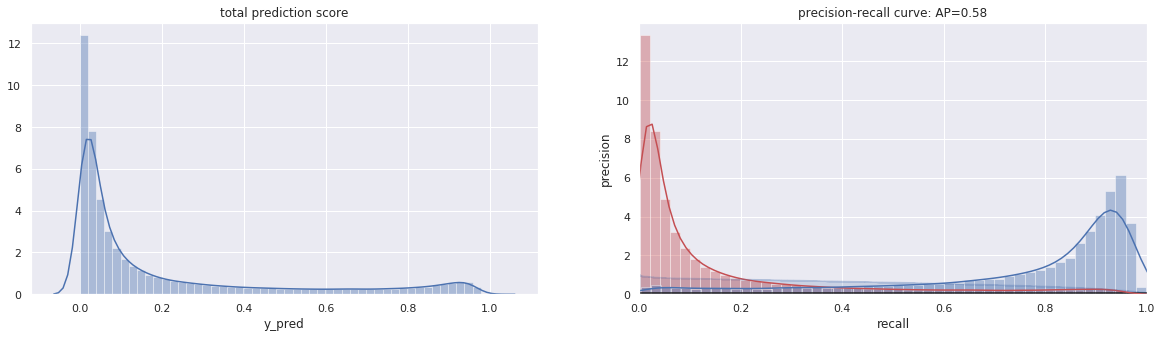

{'result':         y_true    y_pred  y_pred_class
 0            0  0.323768             0
 1            0  0.009810             0
 2            0  0.081780             0
 3            0  0.027244             0
 4            0  0.034337             0
 ...        ...       ...           ...
 380083       0  0.255187             0
 380084       0  0.046034             0
 380085       0  0.068996             0
 380086       0  0.009225             0
 380087       0  0.210516             0
 
 [380088 rows x 3 columns],
 'metrics':         acc    recall  precision  f1_score       auc
 0  0.890644  0.827247   0.380545  0.521289  0.932804,
 'confusion_matrix':          pred: 1  pred: 0
 true: 1    22631     4726
 true: 0    36839   315892,
 'feature_importance':                        feature  importance
 0                       sex_cd         123
 1                          age        1061
 2              mng_nice_cb_scr         466
 3              svc_scrb_period         566
 4              

In [69]:
evaluate(df_tst[feature_cols], df_tst[target_col], clf, clf_name='lgb')